In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# load
data = pd.read_csv("metro_heat_index.csv")

# Preprocessing


# forward-filling with NaN last year is better than dropping the rows
data.ffill(inplace=True)

# metadata and time data
meta_columns = ["RegionID", "SizeRank", "RegionName", "RegionType", "StateName"]
time_series_columns = [col for col in data.columns if col not in meta_columns]

# features and target

#  percent change over the last year to define the target and increase column
data["last_year_change"] = (data[time_series_columns[-1]] - data[time_series_columns[-13]]) / data[
  time_series_columns[-13]
]  # percent change over the last year
data["increasing"] = (data["last_year_change"] > 0).astype(int)  # 1 for increasing, 0 otherwise

# Drop rows with missing or invalid values
data.dropna(subset=["last_year_change"], inplace=True)

# dtrees cant use data over time, so we need to flatten the data to increasing over last dataset

# https://www.geeksforgeeks.org/lag-plots/
# rate of change
for i in range(1, 13):  # Lagging for the past 12 months
  data[f"lag_{i}"] = data[time_series_columns[-i]]


# Define features and target
features = [f"lag_{i}" for i in range(1, 13)] # features: 
X = data[features]
y = data["increasing"]

# time based split; older data for training and newer data for testing
split_date = int(0.8 * len(X))  # .8 for training
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

# do i need to scale?
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



RandomForestClassifier(random_state=42)

In [ ]:
# model training

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [31]:

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Mean Squared Error: 0.1881720430107527
Accuracy: 0.8118279569892473
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88       130
           1       0.89      0.43      0.58        56

    accuracy                           0.81       186
   macro avg       0.84      0.70      0.73       186
weighted avg       0.83      0.81      0.79       186



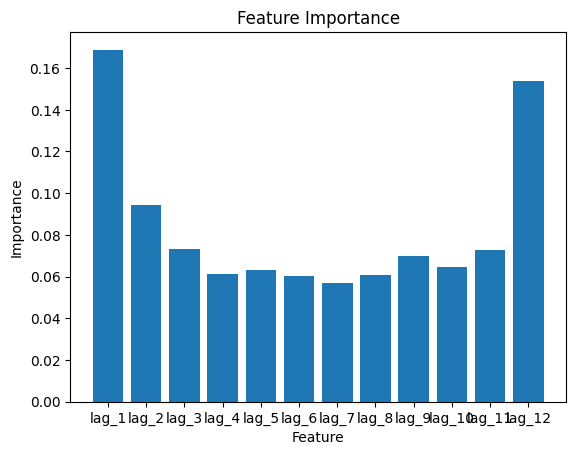

In [ ]:

# plot feature importance
importances = rf_model.feature_importances_
plt.bar(features, importances)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()
